In [27]:
!pip install pandas tqdm
!pip install wordcloud
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls
!pwd

drive  sample_data
/content


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import torch
from transformers import ElectraTokenizer, ElectraForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from tqdm import tqdm
import time
import torch
from wordcloud import WordCloud
import json

sns.set()

In [5]:
torch.cuda.is_available()

True

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/bvidgen/Dynamically-Generated-Hate-Speech-Dataset/main/Dynamically%20Generated%20Hate%20Dataset%20v0.2.3.csv')
df

,Unnamed: 0,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched
0,1,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
1,2,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
2,3,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN
3,4,acl1000,4,I'm not saying we should actually eliminate he...,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN
4,5,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41139,117100,acl9974,41228,Indian culture is so backwards,hate,notgiven,notgiven,original,test,1,GNZuCtwed3,1,NaN
41140,118100,acl11574,1752,"Women don't want equality, they just want to b...",hate,derogation,wom,original,train,2,CAgNlUizNm,2a,acl11575
41141,119100,acl13446,3832,fuck covid,nothate,none,none,original,train,2,CAgNlUizNm,2a,acl13447
41142,1205,acl13457,3844,This computer is garbage,nothate,none,none,original,train,2,eLGzdD8Tvb,2a,acl13458


In [7]:
i = 10
for col in df.columns:
    i += 1
    print(col, end=', ')
    if i % 10 == 0:
        print()

Unnamed: 0, acl.id, X1, text, label, type, target, level, split, round.base, 
annotator, round, acl.id.matched, 

In [8]:
analize_df = df[['text', 'label']]
analize_df

,text,label
0,dalits are lowlives,hate
1,gay people are a burden to our society,hate
2,Arabs are not welcome,hate
3,I'm not saying we should actually eliminate he...,hate
4,bananas are for black people,hate
...,...,...
41139,Indian culture is so backwards,hate
41140,"Women don't want equality, they just want to b...",hate
41141,fuck covid,nothate
41142,This computer is garbage,nothate


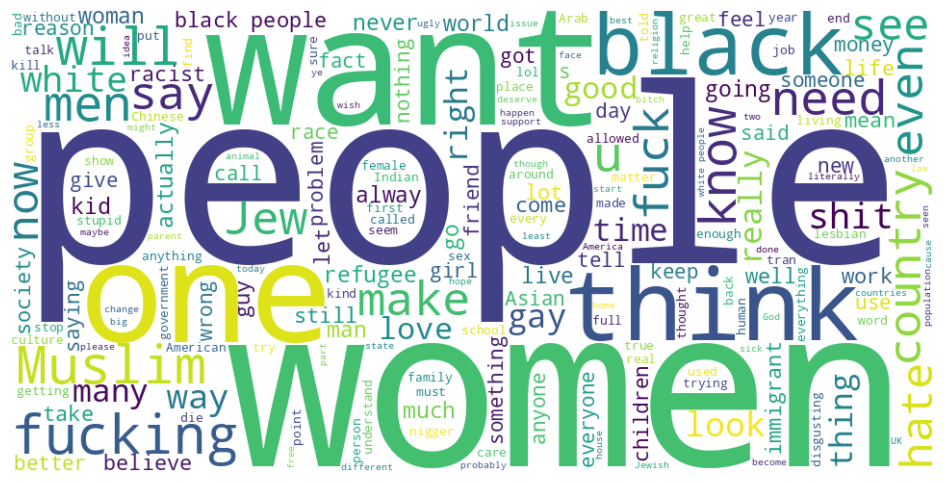

In [9]:
plt.figure(figsize=(12, 6))

text = " ".join(list(analize_df['text']))

wordcloud = WordCloud(width=960, height=480, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


plt.savefig('/content/drive/MyDrive/Repos/small-electra-for-hate/figures/Wordcloud_of_not_processed_text.png')
plt.show()

In [10]:
word_count = analize_df['text'].apply(lambda x: len(list(x.split())))
print("Max word count in crude texts:", max(word_count))

Max word count in crude texts: 402


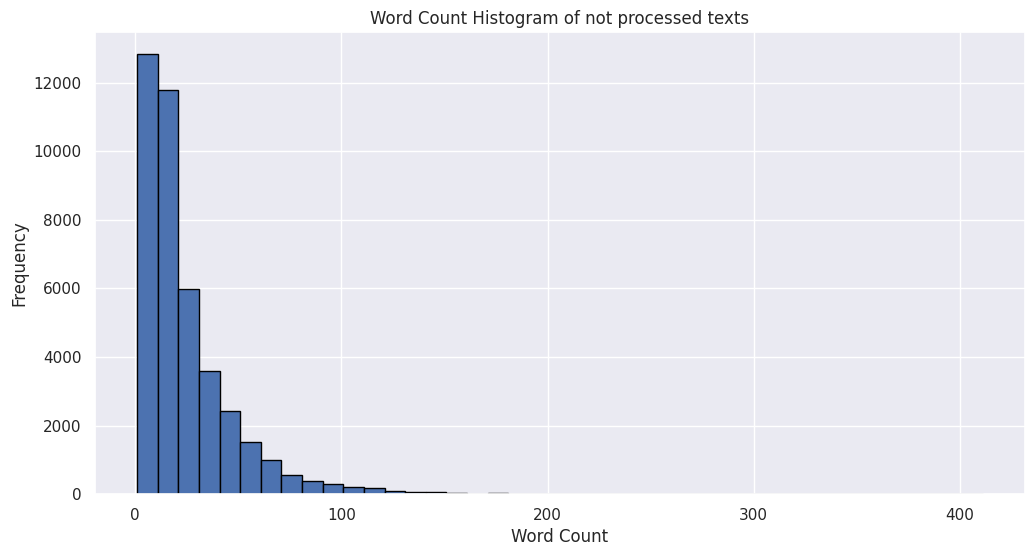

In [11]:
plt.figure(figsize=(12, 6))

plt.hist(word_count, bins=range(min(word_count), max(word_count) + 15, 10), edgecolor='black')

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Histogram of not processed texts')
plt.savefig('/content/drive/MyDrive/Repos/small-electra-for-hate/figures/Histogram_Word_count_not_processed.png')
plt.show()

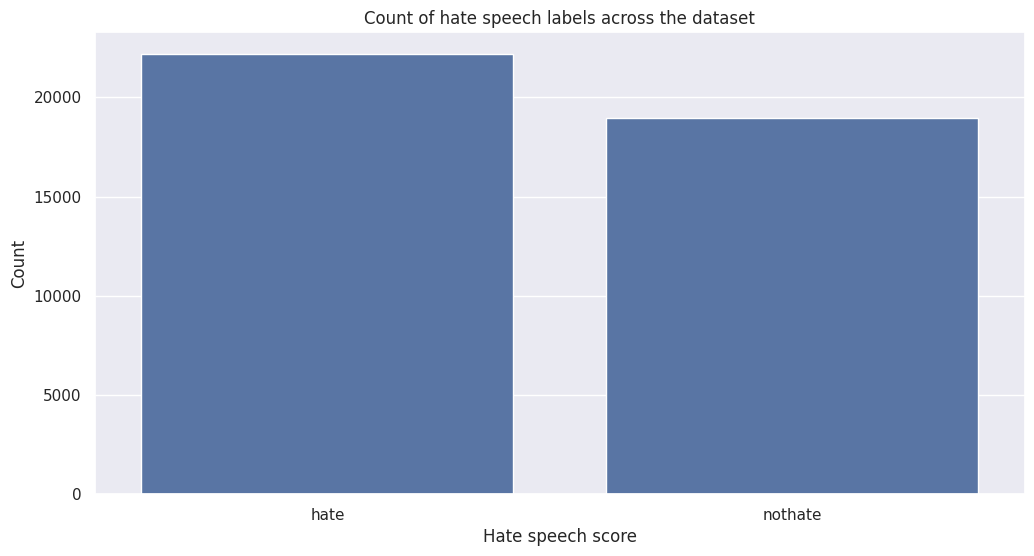

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=analize_df)
plt.xlabel("Hate speech score")
plt.ylabel("Count")
plt.title("Count of hate speech labels across the dataset")
plt.savefig('/content/drive/MyDrive/Repos/small-electra-for-hate/figures/Count_of_hate_speech_labels_across_the_dataset.png')
plt.show()


In [13]:
analize_df.dtypes

text     object
label    object
dtype: object

In [14]:
analize_df['labels'] =  analize_df['label'].apply(lambda x: int(x == 'hate'))
analize_df.head()

<ipython-input-14-907e51d83918>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analize_df['labels'] =  analize_df['label'].apply(lambda x: int(x == 'hate'))


,text,label,labels
0,dalits are lowlives,hate,1
1,gay people are a burden to our society,hate,1
2,Arabs are not welcome,hate,1
3,I'm not saying we should actually eliminate he...,hate,1
4,bananas are for black people,hate,1


In [15]:
analize_df = analize_df[['text', 'labels']]
analize_df['text'] = analize_df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())
analize_df.head()

<ipython-input-15-281b3f733eec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analize_df['text'] = analize_df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())


,text,labels
0,dalits are lowlives,1
1,gay people are a burden to our society,1
2,arabs are not welcome,1
3,im not saying we should actually eliminate hee...,1
4,bananas are for black people,1


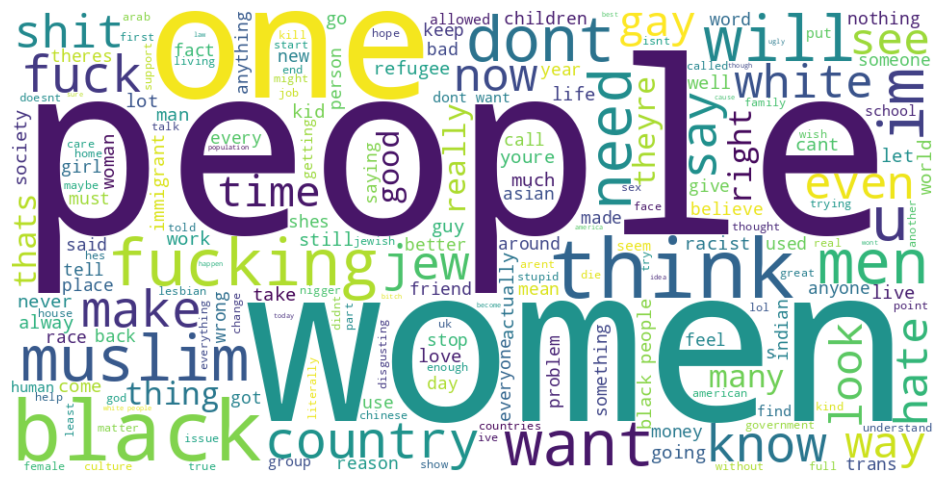

In [16]:
plt.figure(figsize=(12, 6))

text = " ".join(list(analize_df['text']))

wordcloud = WordCloud(width=960, height=480, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


plt.savefig('/content/drive/MyDrive/Repos/small-electra-for-hate/figures/Wordcloud_of_processed_text.png')
plt.show()

In [17]:
word_count = analize_df['text'].apply(lambda x: len(list(x.split())))
print("Max word count in preprocessed texts:", max(word_count))

Max word count in preprocessed texts: 400


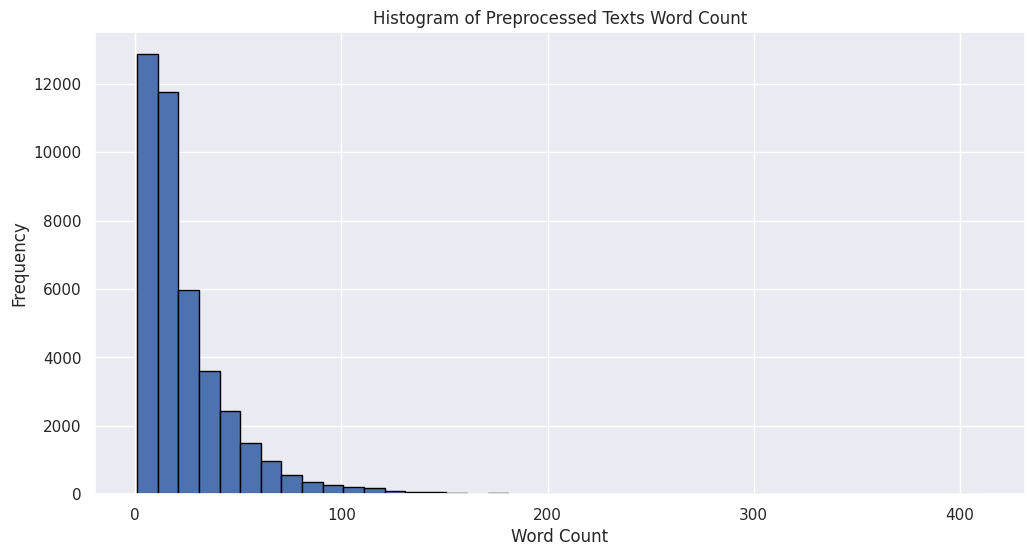

In [18]:
plt.figure(figsize=(12, 6))

plt.hist(word_count, bins=range(min(word_count), max(word_count) + 15, 10), edgecolor='black')

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Preprocessed Texts Word Count')
plt.savefig('/content/drive/MyDrive/Repos/small-electra-for-hate/figures/Word_Count_Histogram_Preprocessed_texts.png')
plt.show()

In [19]:
X = analize_df[['text']]
y = analize_df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [20]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [21]:
class TransformerModel:
  def __init__(self, tokenizer_class, tokenizer_name, model_class, model_name):
    self.batch_size = 32
    self.max_length = 512
    self.num_epochs = 50
    self.learning_rate = 4e-5
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.tokenizer = tokenizer_class.from_pretrained(tokenizer_name)
    self.model = model_class.from_pretrained(model_name).to(self.device)
    self.optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)



  def create_dataloader(self, texts, labels):
    dataset = CustomDataset(list(texts), list(labels), self.tokenizer, self.max_length)
    return DataLoader(dataset, batch_size=self.batch_size)

  def fit(self, train_loader):
    self.loss_list = list()
    start_time = time.time()
    for epoch in range(self.num_epochs):
      self.model.train()
      total_loss = 0
      for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False):
          self.optimizer.zero_grad()

          input_ids = batch['input_ids'].to(self.device)
          attention_mask = batch['attention_mask'].to(self.device)
          labels = batch['labels'].to(self.device)

          outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)

          loss = outputs.loss
          total_loss += loss.item()

          loss.backward()
          self.optimizer.step()
      avg_loss = total_loss / len(train_loader)
      print("avg_loss", avg_loss)
      self.loss_list.append(avg_loss)
      self.model.save_pretrained(f'/content/drive/MyDrive/Repos/small-electra-for-hate/models/old/se4hate-epoch-{epoch + 1}/')
    end_time = time.time()
    total_time = end_time - start_time
    self.total_time = total_time

  def predict(self, texts):
    predictions = []
    for text in list(texts):
        inputs = self.tokenizer(text,
                                return_tensors='pt',
                                max_length=self.max_length,
                                truncation=True,
                                padding='max_length')

        inputs = {key: value.to(self.device) for key, value in inputs.items()}
        outputs = self.model(**inputs)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()
        predictions.append(predicted_label)
    return predictions

  def score(self, texts, y):
    preds = self.predict(texts)
    return f1_score(y, preds)

In [22]:
se4hate = TransformerModel(ElectraTokenizer,
                          'google/electra-small-discriminator',
                          ElectraForSequenceClassification,
                          'google/electra-small-discriminator')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW ins

In [23]:
print("Creating Dataloader")
dataloader = se4hate.create_dataloader(X_train['text'], y_train)
print("Training model")
se4hate.fit(dataloader)
print("Ending")

Creating Dataloader
Training model


avg_loss 0.5631232303380966


avg_loss 0.4456438472867012


avg_loss 0.37890825072924295


avg_loss 0.3345259328848786


avg_loss 0.2843294814477364


avg_loss 0.24418880858148137


avg_loss 0.2138536795021759


avg_loss 0.19233911608863208


avg_loss 0.16527999790178405


avg_loss 0.14184693046172875


avg_loss 0.13030496975613964


avg_loss 0.11295529295483397


avg_loss 0.10270435514601155


avg_loss 0.09516944503243495


avg_loss 0.08055753495673545


avg_loss 0.07808855677579736


avg_loss 0.07311331915306962


avg_loss 0.06630236691640069


avg_loss 0.06248957173504298


avg_loss 0.05896469544580517


avg_loss 0.05450402498717368


avg_loss 0.04723828398842468


avg_loss 0.04541781684661853


avg_loss 0.04399031276348978


avg_loss 0.04566566510281215


avg_loss 0.03881647266997283


avg_loss 0.04048124641079792


avg_loss 0.03778854129590198


avg_loss 0.03668527012202604


avg_loss 0.0343506786088498


avg_loss 0.032850871130778815


avg_loss 0.0359894388562922


avg_loss 0.03131753254183827


avg_loss 0.03054240424952392


avg_loss 0.027690719915909642


avg_loss 0.027997424739458238


avg_loss 0.028146399087951673


avg_loss 0.023936940100328583


avg_loss 0.025328767109668762


avg_loss 0.024663365978146126


avg_loss 0.023398247468640977


avg_loss 0.025033001943649852


avg_loss 0.024461977142653066


avg_loss 0.02294595600351588


avg_loss 0.02181973940544089


avg_loss 0.022475625384104206


avg_loss 0.022496716678659948


avg_loss 0.022763298321094933


avg_loss 0.01973460766572518


avg_loss 0.019402813211636383
Ending


In [ ]:
del se4hate

In [ ]:
se4hate = TransformerModel(ElectraTokenizer,
                          'google/electra-small-discriminator',
                          ElectraForSequenceClassification,
                          'google/electra-small-discriminator')

In [24]:
f1_train_list = list()
f1_test_list = list()

for epoch in range(se4hate.num_epochs):
    print('Evaluating EPOCH', epoch + 1)
    del se4hate.model
    se4hate.model = ElectraForSequenceClassification.from_pretrained(f'/content/drive/MyDrive/Repos/small-electra-for-hate/models/old/se4hate-epoch-{epoch + 1}/')
    se4hate.model.to(se4hate.device)
    f1_train = se4hate.score(X_train['text'], y_train)
    f1_test = se4hate.score(X_test['text'], y_test)
    f1_train_list.append(f1_train)
    f1_test_list.append(f1_test)

Evaluating EPOCH 1
Evaluating EPOCH 2
Evaluating EPOCH 3
Evaluating EPOCH 4
Evaluating EPOCH 5
Evaluating EPOCH 6
Evaluating EPOCH 7
Evaluating EPOCH 8
Evaluating EPOCH 9
Evaluating EPOCH 10
Evaluating EPOCH 11
Evaluating EPOCH 12
Evaluating EPOCH 13
Evaluating EPOCH 14
Evaluating EPOCH 15
Evaluating EPOCH 16
Evaluating EPOCH 17
Evaluating EPOCH 18
Evaluating EPOCH 19
Evaluating EPOCH 20
Evaluating EPOCH 21
Evaluating EPOCH 22
Evaluating EPOCH 23
Evaluating EPOCH 24
Evaluating EPOCH 25
Evaluating EPOCH 26
Evaluating EPOCH 27
Evaluating EPOCH 28
Evaluating EPOCH 29
Evaluating EPOCH 30
Evaluating EPOCH 31
Evaluating EPOCH 32
Evaluating EPOCH 33
Evaluating EPOCH 34
Evaluating EPOCH 35
Evaluating EPOCH 36
Evaluating EPOCH 37
Evaluating EPOCH 38
Evaluating EPOCH 39
Evaluating EPOCH 40
Evaluating EPOCH 41
Evaluating EPOCH 42
Evaluating EPOCH 43
Evaluating EPOCH 44
Evaluating EPOCH 45
Evaluating EPOCH 46
Evaluating EPOCH 47
Evaluating EPOCH 48
Evaluating EPOCH 49
Evaluating EPOCH 50


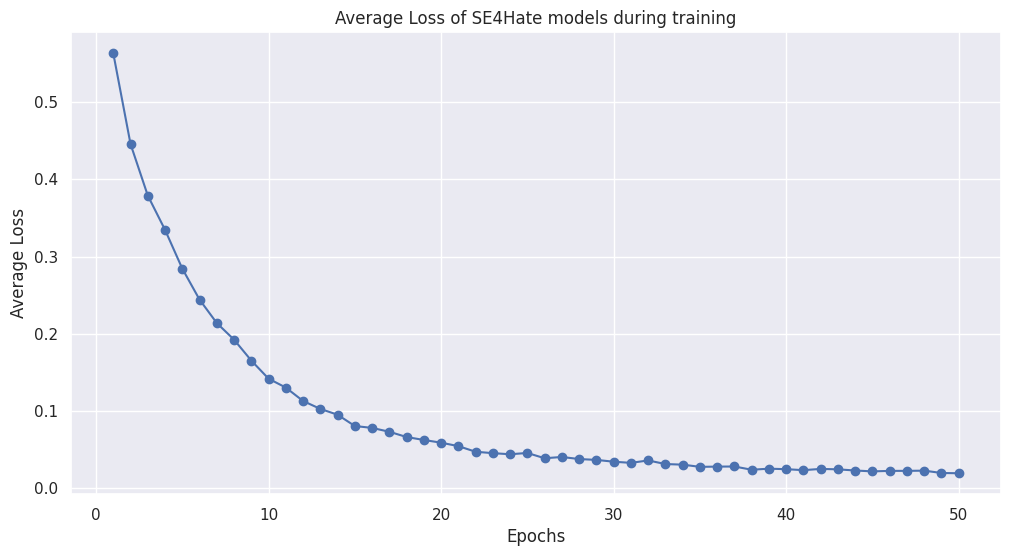

In [31]:
plt.figure(figsize=(12, 6))

epoch_list = list(range(1,51))
plt.plot(epoch_list, se4hate.loss_list, marker='o')

plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Average Loss of SE4Hate models during training')

plt.savefig('/content/drive/MyDrive/Repos/small-electra-for-hate/figures/Average_Loss_of_SE4Hate_per_epoch.png')

plt.show()

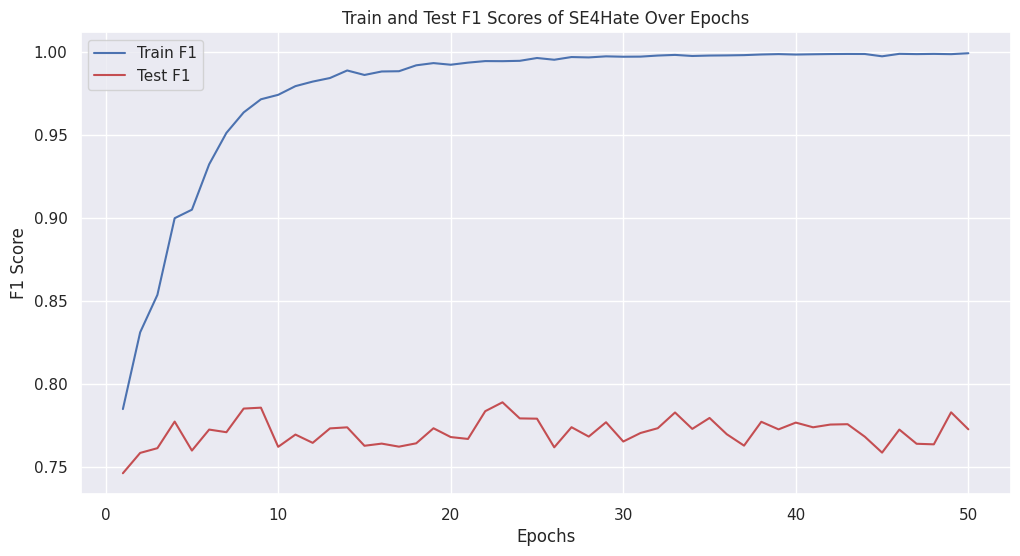

In [32]:
epoch_list = [i + 1 for i in range(se4hate.num_epochs)]

plt.figure(figsize=(12, 6))

plt.plot(epoch_list, f1_train_list, 'b', label='Train F1')
plt.plot(epoch_list, f1_test_list, 'r', label='Test F1')

plt.title('Train and Test F1 Scores of SE4Hate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.savefig('/content/drive/MyDrive/Repos/small-electra-for-hate/figures/Train_and_Test_F1_Scores_of_SE4Hate_Over_Epochs.png')
plt.show()

In [33]:
best_model = -1
best_test_score = -1
for i in range(se4hate.num_epochs):
    if f1_test_list[i] > best_test_score:
        best_model = i + 1
        best_test_score = f1_test_list[i]

In [34]:
del se4hate.model
se4hate.model = ElectraForSequenceClassification.from_pretrained(f'/content/drive/MyDrive/Repos/small-electra-for-hate/models/old/se4hate-epoch-{best_model}/')
se4hate.model.to(se4hate.device)
se4hate.model.save_pretrained('/content/drive/MyDrive/Repos/small-electra-for-hate/models/best_model/se4hate/')

In [36]:
metadata = {
    'f1_train_list': f1_train_list,
    'f1_test_list': f1_test_list,
    'training_time': se4hate.total_time,
    'loss_list': se4hate.loss_list,
    'best_model': best_model,
    'best_score': best_test_score,
    'tokenizer_name': 'google/electra-small-discriminator',
    'tokenizer_class': 'ElectraTokenizer',
    'model_class': 'ElectraForSequenceClassification'
}

json_data = json.dumps(metadata)

with open('/content/drive/MyDrive/Repos/small-electra-for-hate/results/results.json', 'w') as file:
    file.write(json_data)

In [37]:
print(metadata)

{'f1_train_list': [0.784713111924325, 0.8309416427497608, 0.8535322569657333, 0.8997289972899728, 0.9048588490770901, 0.932212401143085, 0.9511466911644083, 0.9634780389780231, 0.9713884724570189, 0.9740763687351225, 0.9793103448275863, 0.9820518645938139, 0.9842006835622622, 0.988751007252216, 0.9860441019331022, 0.9881445970458668, 0.9882955613915636, 0.991858361333678, 0.9931937679429697, 0.9922155108369134, 0.9934750306867369, 0.994405864197531, 0.9943539073527525, 0.9945667899051599, 0.9962648119526017, 0.9952153110047847, 0.9968417660328714, 0.9966132309776473, 0.9972622153509195, 0.9970309171884076, 0.9970969614863557, 0.9977445547106587, 0.9981321653999743, 0.997483546264034, 0.9977454264364853, 0.9978386399561275, 0.9979998709594168, 0.9983895903117752, 0.9986148245981381, 0.9983577523748188, 0.9985182321865739, 0.9986468200270637, 0.9987118382068787, 0.9986783146900488, 0.9972885732730795, 0.9987753786658072, 0.9986133952468479, 0.9987427871441926, 0.9985838429353073, 0.99913

In [39]:
print("best model at epoch", best_model)
print()

best model at epoch 23


In [38]:
"Thats all folks"

'Thats all folks'